# Mini Project - Modified ResNet Architecture with CIFAR-10 images

**Goal:** In this mini-project we are tasked with coming up 
with a modified residual network (ResNet)
architecture with the **highest test accuracy** on the CIFAR-10 image classification dataset, under the
constraint that our model has **no more than 5 million parameters**.

## Dataset loading and importing packages

We would be using **CIFAR-10 image classification dataset** which has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size. This dataset can be loaded using the **torchvision** package.



In [82]:
# Importing packages
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import random

from torchsummary import summary
from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [83]:
# Ensure that you create a folder dlf22_mini_project in your drive account
from google.colab import drive
drive.mount('/content/drive')
proj_root = '/content/drive/MyDrive/dlf22_mini_project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Training, Validation and Testing Dataloaders 

The training and validation dataloaders are split from the train directory using random seed shuffling of indices. The training dataloader then uses train transformations and batch size 128 which the validation dataloader uses the test transformations with batch size 100. The testing dataset comes from test directory, and dataloader uses test transformations and batch size 100.

In [84]:
# Loading and Transforming dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Train dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Validation dataset
valid_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform_test,
    )

# Train - validation split
num_train = len(trainset)
indices = list(range(num_train))
# Size of validation dataset
valid_size = 0.1
split = int(np.floor(valid_size * num_train))
# Shuffle the dataset indices
random_seed = random.seed(30)
np.random.seed(random_seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders for train and validation dataset
train_iterator= torch.utils.data.DataLoader(
        trainset, batch_size=128, sampler=train_sampler,
        num_workers=2
    )
valid_iterator = torch.utils.data.DataLoader(
        valid_dataset, batch_size=100, sampler=valid_sampler,
        num_workers=2
    )

    
# Test dataset and loader
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_iterator = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Target classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [85]:
# Define our device as the first visible cuda device if we have CUDA available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Plotting some examples

Now let's check some of the images data we have

In [86]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [87]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [trainset[i] for i in range(N_IMAGES)]])

classes = testset.classes

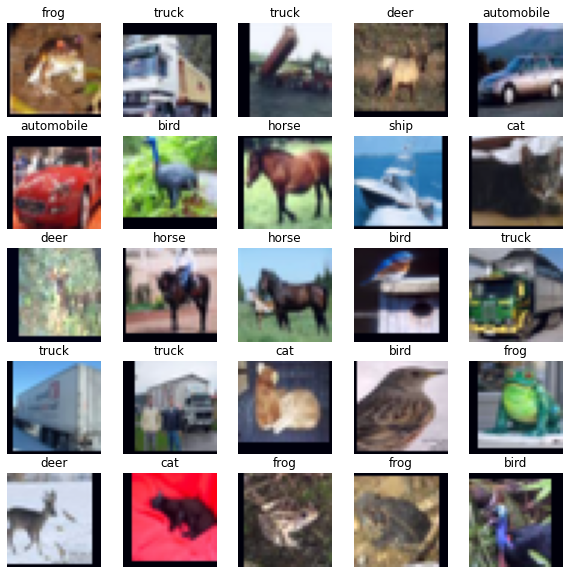

In [88]:
plot_images(images, labels, classes, normalize = True)

## Defining the ResNet

In [89]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

Created a custom Resnet function to test all configurations

In [90]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_channels = [64, 128, 256, 512], strides = [1, 2, 2, 2], linear_in= 512, in_planes = 64, avg_pool_size = 4, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.layers_list = []
        for i in range(len(num_blocks)):
            # Makes layers based on the num_blocks, num_channels, strides given
            self.layers_list.append(self._make_layer(block, num_channels[i], num_blocks[i], stride=strides[i]))
        self.layer1 = nn.Sequential(*self.layers_list)
        self.linear = nn.Linear(linear_in*block.expansion, num_classes)
        self.avg_pool_size = avg_pool_size

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = F.avg_pool2d(out, self.avg_pool_size)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Testing different configurations of Resnet-18

### Setting up different configurations

Experimented with:

Configuration 1 - Reducing number of blocks

Configuration 2 - Reducing number of layers and blocks

Configuration 3 - Reducing number of layers, blocks and increasing number of channels 

Configuration 4 - Reducing number of layers, blocks, increasing number of channels and modifying average pool kernel size 

Configuration 5 - Same configuration as configuration 3 but changing number of initial residual layer to 128 i.e., 128->128->256->512

Configuration 6 - Same configuration as configuration 4 but changing number of initial residual layer to 128 i.e., 128->128->256->512

In [91]:
models = []

In [92]:
# Original Resnet-18
net = ResNet(BasicBlock, [2, 2, 2, 2], [64, 128, 256, 512], [1, 2, 2, 2])
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [93]:
# Reducing number of residual blocks
net1 = ResNet(BasicBlock, [2, 1, 1, 1], [64, 128, 256, 512], [1, 2, 2, 2])
models.append(net1)
net1 = net1.to(device)
summary(net1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [94]:
# residual layer reduction and residual block modification 
net2 = ResNet(BasicBlock, [4, 4, 3], [64, 128, 256], [1, 2, 2], 1024)
models.append(net2)
net2 = net2.to(device)
summary(net2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [95]:
# reducing residual layer, reducing residual block and increasing number of chan modification
net3 = ResNet(BasicBlock, [1, 1, 1], [128, 256, 512], [1, 2, 2], 2048)
models.append(net3)
net3 = net3.to(device)
summary(net3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7          [-1, 128, 32, 32]           8,192
       BatchNorm2d-8          [-1, 128, 32, 32]             256
        BasicBlock-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         294,912
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]         589,824
      BatchNorm2d-13          [-1, 256, 16, 16]             512
           Conv2d-14          [-1, 256,

In [96]:
# reducing residual layer, reducing residual block, increasing number of channels, modifying average pool kernel size 
net4 = ResNet(BasicBlock, [1, 1, 1], [128, 256, 512], [1, 2, 2], 8192, avg_pool_size = 2)
models.append(net4)
net4 = net4.to(device)
summary(net4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7          [-1, 128, 32, 32]           8,192
       BatchNorm2d-8          [-1, 128, 32, 32]             256
        BasicBlock-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         294,912
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]         589,824
      BatchNorm2d-13          [-1, 256, 16, 16]             512
           Conv2d-14          [-1, 256,

In [97]:
# reducing residual layer, reducing residual block, in planes = 128 and increasing number of chan modification
net5 = ResNet(BasicBlock, [1, 1, 1], [128, 256, 512], [1, 2, 2], 2048, in_planes=128)
models.append(net5)
net5 = net5.to(device)
summary(net5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 16, 16]         294,912
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]          32,768
      BatchNorm2d-13          [-1, 256, 16, 16]             512
       BasicBlock-14          [-1, 256,

In [98]:
# reducing residual layer, reducing residual block, increasing number of channels, modifying average pool kernel size, in_planes = 128 
net6 = ResNet(BasicBlock, [1, 1, 1], [128, 256, 512], [1, 2, 2], 8192, in_planes=128, avg_pool_size = 2)
models.append(net6)
net6 = net6.to(device)
summary(net6, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 16, 16]         294,912
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]          32,768
      BatchNorm2d-13          [-1, 256, 16, 16]             512
       BasicBlock-14          [-1, 256,

### Training and Testing them to compare performances

In [99]:
import os
import time

Change the model below to train each network.

In [100]:
# Specify the model configuration to use
model_num = 6

In [101]:
model = models[model_num-1].to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [103]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [104]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Change the checkpoint name below to save different model checkpoints. We are saving the model state, validation accuracy for each epoch in checkpoints. We are also printing validation loss and accuracy for each epoch.

In [105]:
def train(net, iterator, optimizer, criterion, device):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(iterator):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return train_loss / (batch_idx+1), 100.*correct / total

In [106]:
def evaluate(net, iterator, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)


    return test_loss / (batch_idx+1), 100.*correct / total

In [107]:
import time

def current_seconds_time():
    return round(time.time())

In [ ]:
EPOCHS = 40

total_start_time = current_seconds_time()
best_valid_acc = 0
for epoch in range(EPOCHS):
  start_time = current_seconds_time()
  train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_accuracy = evaluate(model, valid_iterator, criterion, device)
  if valid_accuracy > best_valid_acc:
    save_location = f"{proj_root}/model_"+str(model_num)+".pt"
    torch.save(model, save_location)
    best_valid_acc = valid_accuracy
  end_time = current_seconds_time()
  elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
  print('Epoch %s, Train loss %s, Valid loss %s, Train accuracy %s, Valid accuracy %s Elapsed mins %s Elapsed secs %s'%(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy, elapsed_mins, elapsed_secs))
total_end_time = current_seconds_time()
full_mins, full_secs = epoch_time(total_start_time, total_end_time)

Epoch 0, Train loss 1.5432998839427123, Valid loss 1.2360077333450317, Train accuracy 44.95777777777778, Valid accuracy 56.18 Elapsed mins 0 Elapsed secs 44
Epoch 1, Train loss 1.0952703470194882, Valid loss 0.9228616285324097, Train accuracy 60.88444444444445, Valid accuracy 67.56 Elapsed mins 0 Elapsed secs 44
Epoch 2, Train loss 0.8817588317800652, Valid loss 0.7551486396789551, Train accuracy 68.97777777777777, Valid accuracy 73.36 Elapsed mins 0 Elapsed secs 42
Epoch 3, Train loss 0.7475492420860312, Valid loss 0.7479377114772796, Train accuracy 73.51555555555555, Valid accuracy 73.34 Elapsed mins 0 Elapsed secs 43
Epoch 4, Train loss 0.6654799139465798, Valid loss 0.6248440283536911, Train accuracy 76.77777777777777, Valid accuracy 78.64 Elapsed mins 0 Elapsed secs 43
Epoch 5, Train loss 0.5814188099889592, Valid loss 0.6455115741491317, Train accuracy 79.88444444444444, Valid accuracy 78.1 Elapsed mins 0 Elapsed secs 42
Epoch 6, Train loss 0.5280861524357037, Valid loss 0.502410

In [ ]:
print(f"Total time elapsed: {full_mins}m {full_secs}s")
print(f"Best valid accuracy: {best_valid_acc}%")

Total time elapsed: 28m 30s
Best valid accuracy: 90.9%


## Visualizing Performance of different models

In [27]:
overall_result = []
time_taken = [20, 33, 27, 27, 28, 28]
for i, _ in enumerate(models[:model_num]):
  indiv_result = []
  save_location =  f"{proj_root}/model_"+str(i+1)+".pt"
  test_model = torch.load(save_location)
  test_loss, test_acc = evaluate(test_model, test_iterator, criterion, device)
  indiv_result.append(i+1)
  indiv_result.append(test_loss)
  indiv_result.append(test_acc)
  indiv_result.append(time_taken[i])
  overall_result.append(indiv_result)
  # print(test_loss, test_acc)

print(tabulate(overall_result, headers=['Model', 'Test Loss', 'Test Accuracy', 'Time Taken for training in minutes']))


  Model    Test Loss    Test Accuracy    Time Taken for training in minutes
-------  -----------  ---------------  ------------------------------------
      1     0.381942            90.24                                    20
      2     0.414302            91.07                                    33
      3     0.397125            90.27                                    27
      4     0.377553            90.61                                    27
      5     0.407969            90.55                                    28
      6     0.385794            90.79                                    28


## Evaluating the best model

Finally, let's plot the confusion matrix of this model.

In [138]:
best_model_index = 6
save_location =  f"{proj_root}/model_"+str(best_model_index)+".pt"
best_model = torch.load(save_location)

In [139]:
evaluate(best_model, test_iterator, criterion, device)

(0.38579435721039773, 90.79)

In [140]:
def get_predictions(net, iterator, criterion, device):
    net.eval()
    correct = 0
    total = 0
    labels = []
    predicts = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            labels.append(targets)
            predicts.append(predicted)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)


    labels = torch.cat(labels, dim = 0)
    predicts = torch.cat(predicts, dim = 0)
    return labels, predicts

In [141]:
labels, pred_labels = get_predictions(best_model, test_iterator, criterion, device)

90.79


(tensor([3, 8, 8,  ..., 5, 1, 7]), tensor([3, 8, 8,  ..., 5, 1, 7]))

In [142]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

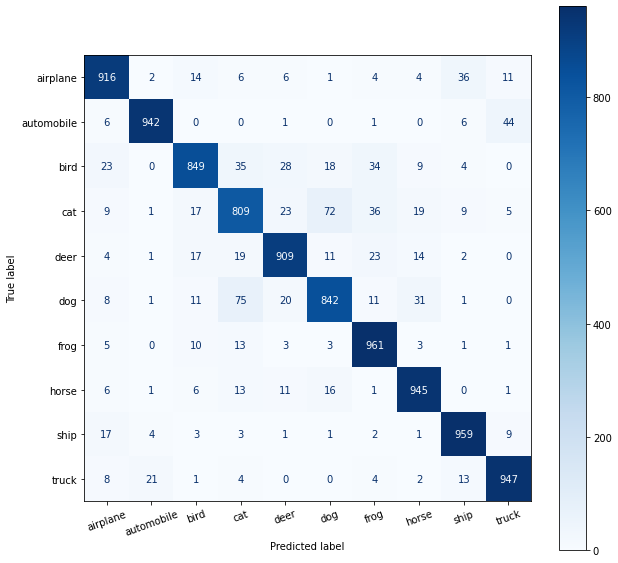

In [143]:
plot_confusion_matrix(labels.cpu(), pred_labels.cpu(), testset.classes) 

## References

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://github.com/kuangliu/pytorch-cifar
3. https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb